## **CHECKLIST**

- [X] Features selezionate (NO tsunami)
- [X] Missing values gestiti
- [X] Scaling applicato (StandardScaler)
- [X] Outliers rimossi (Z-score < 3)
- [X] K ottimale determinato (Elbow Method)
- [X] K-Means applicato (k=4)
- [X] Silhouette Score e Davies-Bouldin Score calcolati
- [X] Cluster visualizzati (2D + 3D per Depth-Magnitude-Sig)
- [X] Profiling cluster (statistiche descrittive)
- [X] Validazione con tsunami rate
- [ ] DBSCAN (Scelta eps migliore - metodo euristico)
- [ ] Cluster visualizzati (mappa geografica)
- [ ] Interpretazione finale

### **Nota:** Usare la libreria yellowbrick ✅

### **Feature Sets:**
1. **Depth-Magnitude-Sig** (3D): Intensità del terremoto
2. **Latitude-Longitude** (2D): Posizione geografica

### **Scelta delle feature (Correlazione):**
- Se |corr| > 0.8, evita di usarle insieme in coppia
- Se 0.3 < |corr| < 0.7, relazione moderata → cluster interpretabili
- Se |corr| < 0.3, aspetti indipendenti → ideale per esplorare strutture nuove


In [2]:
# Dependencies for clustering analysis

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)

## Data Loading

In [3]:
df = pd.read_csv('data/earthquake_data_tsunami.csv')
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


## Data preprocessing

In [4]:
X = df.drop(columns=['tsunami'], axis=1)

# Remove outliers using Z-score method
z_scores = np.abs(stats.zscore(X))
X_clean = X[(z_scores < 3).all(axis=1)]

print(f"Removed {X.shape[0] - X_clean.shape[0]} outliers ({(X.shape[0] - X_clean.shape[0])/X.shape[0]*100:.1f}%)")

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Create feature sets for clustering
# Feature Set 1: Depth-Magnitude-Sig (earthquake intensity)
cols_to_keep = ['depth', 'magnitude', 'sig']
depth_magn_sig_df = pd.DataFrame(X_scaled, columns=X_clean.columns)[cols_to_keep]
depth_magn_sig = depth_magn_sig_df.to_numpy()

# Feature Set 2: Latitude-Longitude (geographic location)
cols_to_keep = ['latitude', 'longitude']
lat_long_df = pd.DataFrame(X_scaled, columns=X_clean.columns)[cols_to_keep]
lat_long = lat_long_df.to_numpy()

features_list = [depth_magn_sig, lat_long]
feature_names = ['Depth-Magnitude-Sig', 'Latitude-Longitude']

Dataset shape after outlier removal: (688, 12)
Removed 94 outliers (12.0%)

Feature sets created:
  Depth-Magnitude-Sig: (688, 3)
  Latitude-Longitude: (688, 2)


## k-Means Clustering

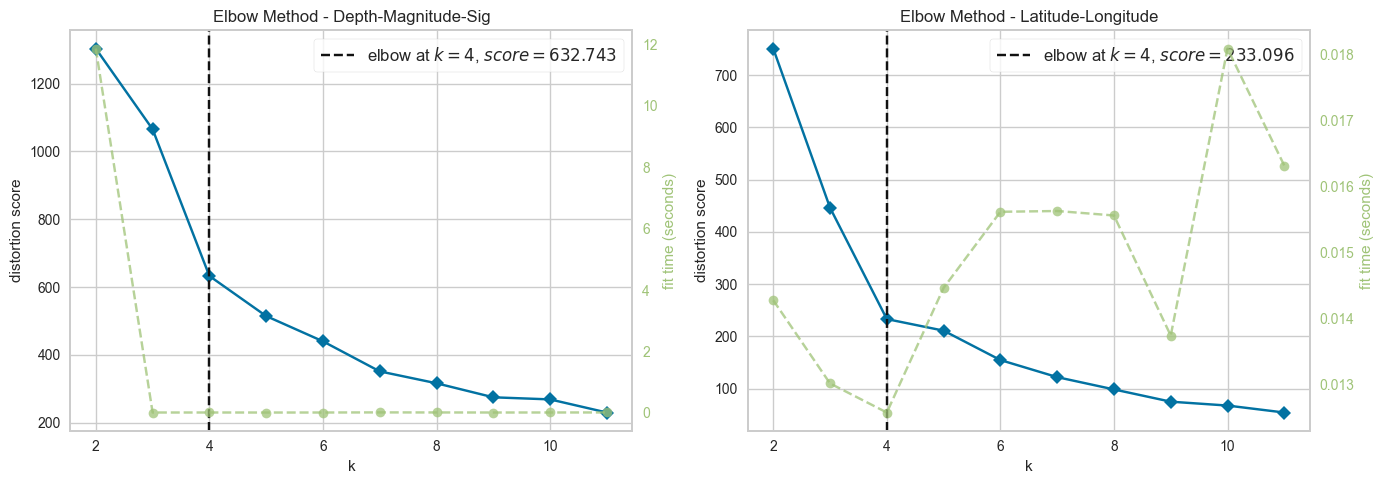

In [5]:
# Elbow method to determine optimal k
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (features, name) in enumerate(zip(features_list, feature_names)):
    model = KMeans(random_state=42)
    visualizer = KElbowVisualizer(model, k=(2, 12), ax=axes[idx])
    visualizer.fit(features)
    visualizer.finalize()
    axes[idx].set_title(f'Elbow Method - {name}')

plt.tight_layout()
plt.show()


### K-Means - Silhoutte Visualization

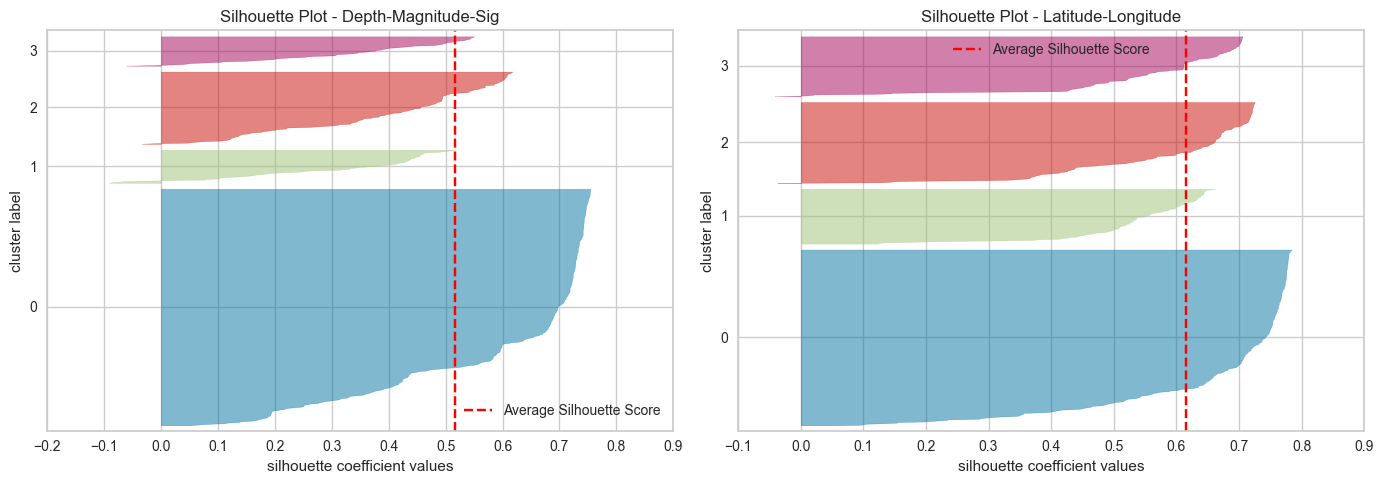

In [6]:
# Fit K-Means models with k=4 (based on elbow method)
km_models = []
y_means_list = []

for features in features_list:
    km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
    y_means = km.fit_predict(features)
    km_models.append(km)
    y_means_list.append(y_means)

# Silhouette visualization for each feature set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (km_model, features, name) in enumerate(zip(km_models, features_list, feature_names)):
    visualizer = SilhouetteVisualizer(km_model, colors='yellowbrick', ax=axes[idx], is_fitted=True)
    visualizer.fit(features)
    visualizer.finalize()
    axes[idx].set_title(f'Silhouette Plot - {name}')

plt.tight_layout()
plt.show()

### K-Means - Cluster Visualization

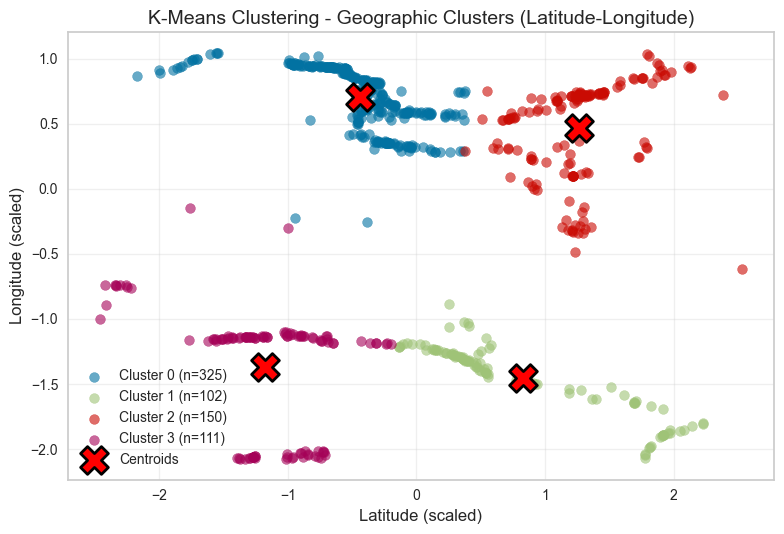

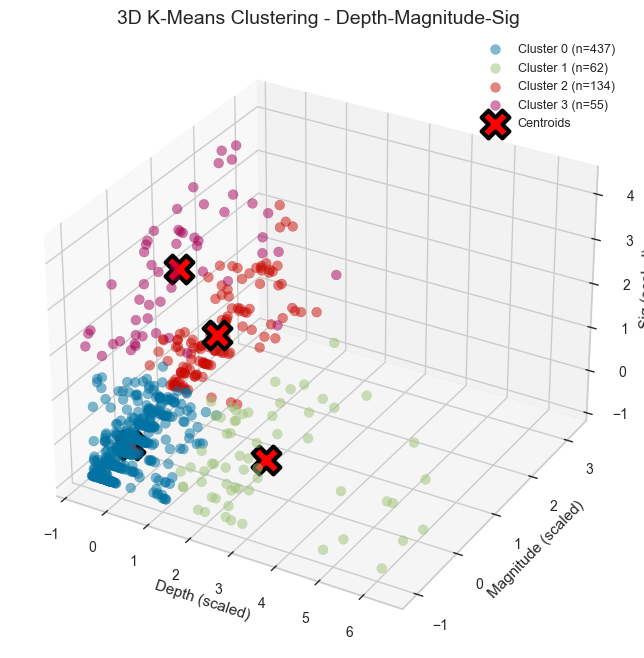

In [7]:
# Use only Latitude-Longitude clusters (index 1)
features = lat_long
y_means = y_means_list[1]
km_model = km_models[1]

# Plot clusters
for cluster in range(4):
    cluster_mask = y_means == cluster
    plt.scatter(features[cluster_mask, 0],
               features[cluster_mask, 1],
               s=50, alpha=0.6, label=f'Cluster {cluster} (n={cluster_mask.sum()})')

# Plot centroids
centroids = km_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='red', s=400, alpha=1, marker='X',
           edgecolors='black', linewidth=2, zorder=1000, label='Centroids')

plt.title(
    'K-Means Clustering - Geographic Clusters (Latitude-Longitude)', fontsize=14)
plt.xlabel('Latitude (scaled)', fontsize=12)
plt.ylabel('Longitude (scaled)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3D visualization for Depth-Magnitude-Sig


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

y_means_3d = y_means_list[0]  # Clusters for depth-magnitude-sig

for cluster in range(4):
    cluster_mask = y_means_3d == cluster
    ax.scatter(depth_magn_sig[cluster_mask, 0],
                depth_magn_sig[cluster_mask, 1],
                depth_magn_sig[cluster_mask, 2],
                s=50, alpha=0.5, label=f'Cluster {cluster} (n={cluster_mask.sum()})',
                depthshade=True)

# Plot centroids last (on top) with higher zorder and no transparency
centroids = km_models[0].cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
            c='red', s=400, alpha=1.0, marker='X',
            edgecolors='black', linewidth=3, label='Centroids',
            depthshade=False, zorder=1000)

ax.set_xlabel('Depth (scaled)', fontsize=11)
ax.set_ylabel('Magnitude (scaled)', fontsize=11)
ax.set_zlabel('Sig (scaled)', fontsize=11)
ax.set_title('3D K-Means Clustering - Depth-Magnitude-Sig', fontsize=14)
ax.legend(loc='best', fontsize=9)
plt.show()

In [8]:
for idx, (name, y_means) in enumerate(zip(feature_names, y_means_list)):
    print(f"\n{name}:")
    print("-" * 40)

    unique, counts = np.unique(y_means, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(
            f"  Cluster {cluster}: {count:4d} samples ({count/len(y_means)*100:5.1f}%)")

    # Silhouette score (higher is better, range [-1, 1])
    sil_score = silhouette_score(features_list[idx], y_means)
    # Davies-Bouldin score (lower is better, range [0, inf])
    db_score = davies_bouldin_score(features_list[idx], y_means)

    print(f"\n  Quality Metrics:")
    print(f"    Silhouette Score:     {sil_score:6.3f} (higher is better)")
    print(f"    Davies-Bouldin Score: {db_score:6.3f} (lower is better)")


Depth-Magnitude-Sig:
----------------------------------------
  Cluster 0:  437 samples ( 63.5%)
  Cluster 1:   62 samples (  9.0%)
  Cluster 2:  134 samples ( 19.5%)
  Cluster 3:   55 samples (  8.0%)

  Quality Metrics:
    Silhouette Score:      0.517 (higher is better)
    Davies-Bouldin Score:  0.803 (lower is better)

Latitude-Longitude:
----------------------------------------
  Cluster 0:  325 samples ( 47.2%)
  Cluster 1:  102 samples ( 14.8%)
  Cluster 2:  150 samples ( 21.8%)
  Cluster 3:  111 samples ( 16.1%)

  Quality Metrics:
    Silhouette Score:      0.615 (higher is better)
    Davies-Bouldin Score:  0.596 (lower is better)


### K-Means - Cluster Profiling

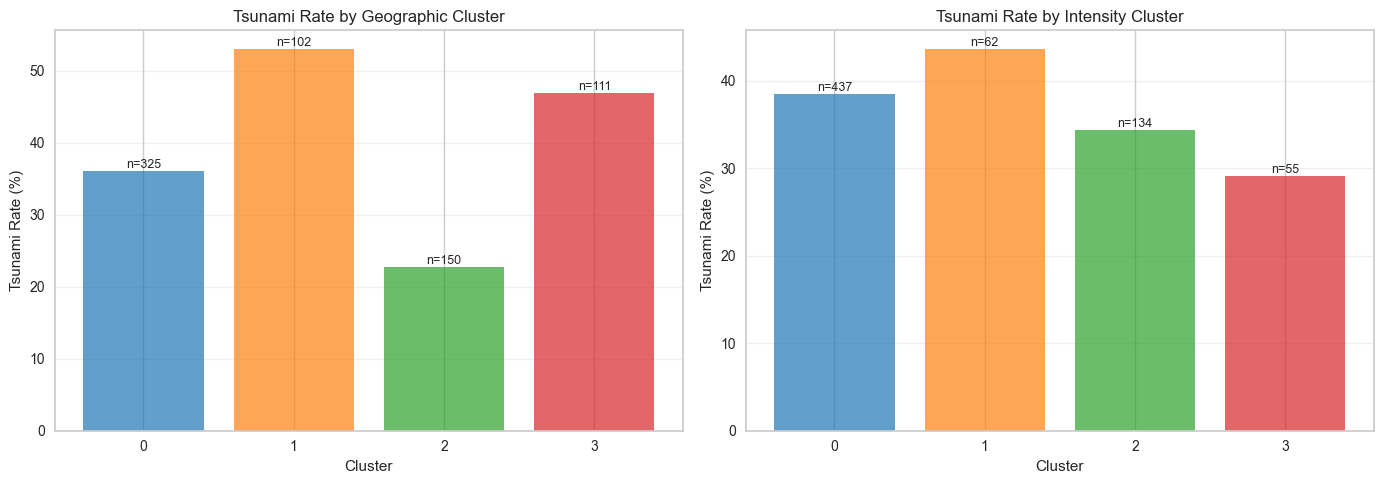

In [9]:
# Add cluster labels to original (cleaned) dataframe
X_clean_with_clusters = X_clean.copy()
X_clean_with_clusters['cluster_geo'] = y_means_list[1]  # Latitude-Longitude clusters
X_clean_with_clusters['cluster_intensity'] = y_means_list[0]  # Depth-Magnitude-Sig clusters

# Add tsunami back for validation
tsunami_clean = df['tsunami'].iloc[X_clean.index]
X_clean_with_clusters['tsunami'] = tsunami_clean.values

# Visualize tsunami rate per cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (cluster_col, name) in enumerate([('cluster_geo', 'Geographic'), ('cluster_intensity', 'Intensity')]):
    tsunami_rates = []
    cluster_sizes = []
    
    for cluster in range(4):
        cluster_data = X_clean_with_clusters[X_clean_with_clusters[cluster_col] == cluster]
        tsunami_rate = cluster_data['tsunami'].mean() * 100
        tsunami_rates.append(tsunami_rate)
        cluster_sizes.append(len(cluster_data))
    
    bars = axes[idx].bar(range(4), tsunami_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Tsunami Rate (%)')
    axes[idx].set_title(f'Tsunami Rate by {name} Cluster')
    axes[idx].set_xticks(range(4))
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add cluster size as text on bars
    for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'n={size}',
                      ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## DBSCAN Hyperparameter Optimization

In [95]:
# Grid search parameters based on k-distance graph analysis
eps_ranges = {
    'Depth-Magnitude-Sig': np.arange(0.40, 0.61, 0.10),  # 0.40, 0.50, 0.60
    'Latitude-Longitude': np.arange(0.10, 0.21, 0.05)   # 0.10, 0.15, 0.20
}

min_samples = 5

# Store all grid search results
grid_search_results = []

for idx, (features, name) in enumerate(zip(features_list, feature_names)):
    
    eps_values = eps_ranges[name]
    
    for eps in eps_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels) * 100
        
        # Initialize metrics
        sil_score = None
        db_score = None
        
        # Calculate quality metrics (only if valid clustering)
        if n_clusters > 1 and n_noise < len(labels):
            mask = labels != -1
            if mask.sum() > 1:
                try:
                    sil_score = silhouette_score(features[mask], labels[mask])
                    db_score = davies_bouldin_score(features[mask], labels[mask])
                except:
                    pass
        
        # Store results
        result = {
            'feature_set': name,
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'labels': labels
        }
        grid_search_results.append(result)

### Best Parameters Selection

In [96]:
# Convert to DataFrame for better analysis
grid_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'labels'}  # Exclude labels array
    for r in grid_search_results
])

# Filter valid results (with silhouette score)
valid_results = grid_df[grid_df['silhouette'].notna()].copy()

# Select best parameters for each feature set
best_params = {}

for feature_set in feature_names:
    subset = valid_results[valid_results['feature_set'] == feature_set].copy()
    
    if len(subset) > 0:
        # Criteria: maximize silhouette, minimize davies_bouldin, reasonable noise (<20%)
        subset_filtered = subset[subset['noise_pct'] < 20]
        
        if len(subset_filtered) == 0:
            subset_filtered = subset  # Fallback if all have high noise
        
        # Sort by composite score: prioritize silhouette
        subset_filtered = subset_filtered.sort_values(['silhouette', 'davies_bouldin'],
                                                      ascending=[False, True])
        
        best = subset_filtered.iloc[0]
        best_params[feature_set] = {
            'eps': best['eps'],
            'min_samples': int(best['min_samples']),
            'n_clusters': int(best['n_clusters']),
            'silhouette': best['silhouette'],
            'davies_bouldin': best['davies_bouldin'],
            'noise_pct': best['noise_pct']
        }

print("\n" + "="*80)
print("BEST PARAMETERS SELECTED")
print("="*80)

for feature_set, params in best_params.items():
    print(f"\n{feature_set}:")
    print(f"  eps:              {params['eps']:.3f}")
    print(f"  min_samples:      {params['min_samples']}")
    print(f"  n_clusters:       {params['n_clusters']}")
    print(f"  noise:            {params['noise_pct']:.1f}%")
    print(f"  Silhouette:       {params['silhouette']:.4f}")
    print(f"  Davies-Bouldin:   {params['davies_bouldin']:.4f}")


BEST PARAMETERS SELECTED

Depth-Magnitude-Sig:
  eps:              0.500
  min_samples:      5
  n_clusters:       3
  noise:            11.2%
  Silhouette:       0.5055
  Davies-Bouldin:   0.3818

Latitude-Longitude:
  eps:              0.150
  min_samples:      5
  n_clusters:       17
  noise:            3.2%
  Silhouette:       0.5261
  Davies-Bouldin:   0.4800


### Apply Best DBSCAN Parameters

In [97]:
# Apply best DBSCAN parameters to create final models
dbscan_optimized_results = []

for idx, (features, name) in enumerate(zip(features_list, feature_names)):
    best = best_params[name]
    
    # Fit DBSCAN with best parameters
    dbscan = DBSCAN(eps=best['eps'], min_samples=best['min_samples'])
    labels = dbscan.fit_predict(features)
    
    # Get the original result from grid search
    result = [r for r in grid_search_results 
              if r['feature_set'] == name 
              and r['eps'] == best['eps'] 
              and r['min_samples'] == best['min_samples']][0]
    
    dbscan_optimized_results.append(result)

for result in dbscan_optimized_results:
    print(f"\n{result['feature_set']}:")
    print("-" * 80)
    # Quality metrics
    if result['silhouette'] is not None:
        print(f"\n  Quality Metrics (excluding noise):")
        print(f"    Silhouette Score:       {result['silhouette']:.4f}")
        print(f"    Davies-Bouldin Score:   {result['davies_bouldin']:.4f}")

print("\n" + "="*80)


Depth-Magnitude-Sig:
--------------------------------------------------------------------------------

  Quality Metrics (excluding noise):
    Silhouette Score:       0.5055
    Davies-Bouldin Score:   0.3818

Latitude-Longitude:
--------------------------------------------------------------------------------

  Quality Metrics (excluding noise):
    Silhouette Score:       0.5261
    Davies-Bouldin Score:   0.4800



### DBSCAN - Silhouette Visualization

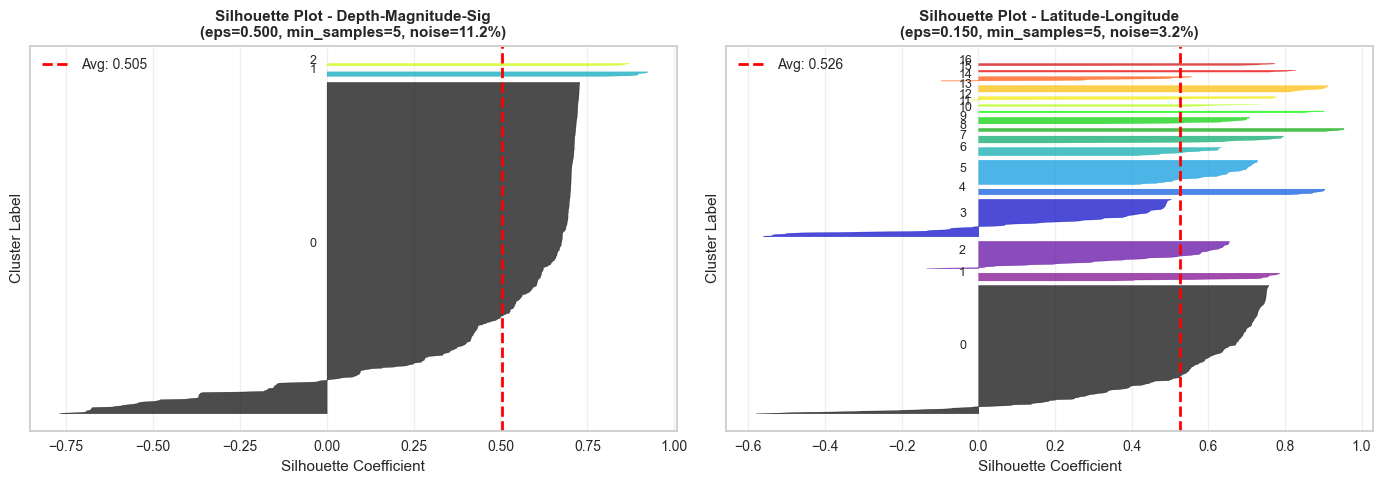

In [98]:
# Silhouette plots for optimized DBSCAN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, result in enumerate(dbscan_optimized_results):
    features = features_list[idx]
    labels = result['labels']
    name = result['feature_set']
    
    mask = labels != -1
    
    if mask.sum() > 0 and result['n_clusters'] > 1:
        silhouette_vals = silhouette_samples(features[mask], labels[mask])
        cluster_labels = sorted(set(labels[mask]))
        
        y_lower = 10
        for i, cluster_label in enumerate(cluster_labels):
            cluster_silhouette_vals = silhouette_vals[labels[mask] == cluster_label]
            cluster_silhouette_vals.sort()
            
            size_cluster = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster
            
            color = plt.cm.nipy_spectral(float(i) / len(cluster_labels))
            axes[idx].fill_betweenx(np.arange(y_lower, y_upper),
                                   0, cluster_silhouette_vals,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            
            axes[idx].text(-0.05, y_lower + 0.5 * size_cluster, str(cluster_label), fontsize=9)
            y_lower = y_upper + 10
        
        axes[idx].set_xlabel('Silhouette Coefficient', fontsize=11)
        axes[idx].set_ylabel('Cluster Label', fontsize=11)
        axes[idx].axvline(x=result['silhouette'], color="red", linestyle="--", 
                         linewidth=2, label=f"Avg: {result['silhouette']:.3f}")
        axes[idx].set_yticks([])
        axes[idx].legend(fontsize=10)
        axes[idx].set_title(f'Silhouette Plot - {name}\n' + 
                           f'(eps={result["eps"]:.3f}, min_samples={result["min_samples"]}, ' +
                           f'noise={result["noise_pct"]:.1f}%)', 
                           fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='x')
    else:
        axes[idx].text(0.5, 0.5, f'Not enough clusters\nfor silhouette analysis\n({result["n_clusters"]} clusters)',
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(f'Silhouette Plot - {name}', fontsize=11, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

### DBSCAN - Cluster Scatter Plots

C:\Users\matti\AppData\Local\Temp\ipykernel_32072\3838180256.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(features_geo[class_mask, 0],


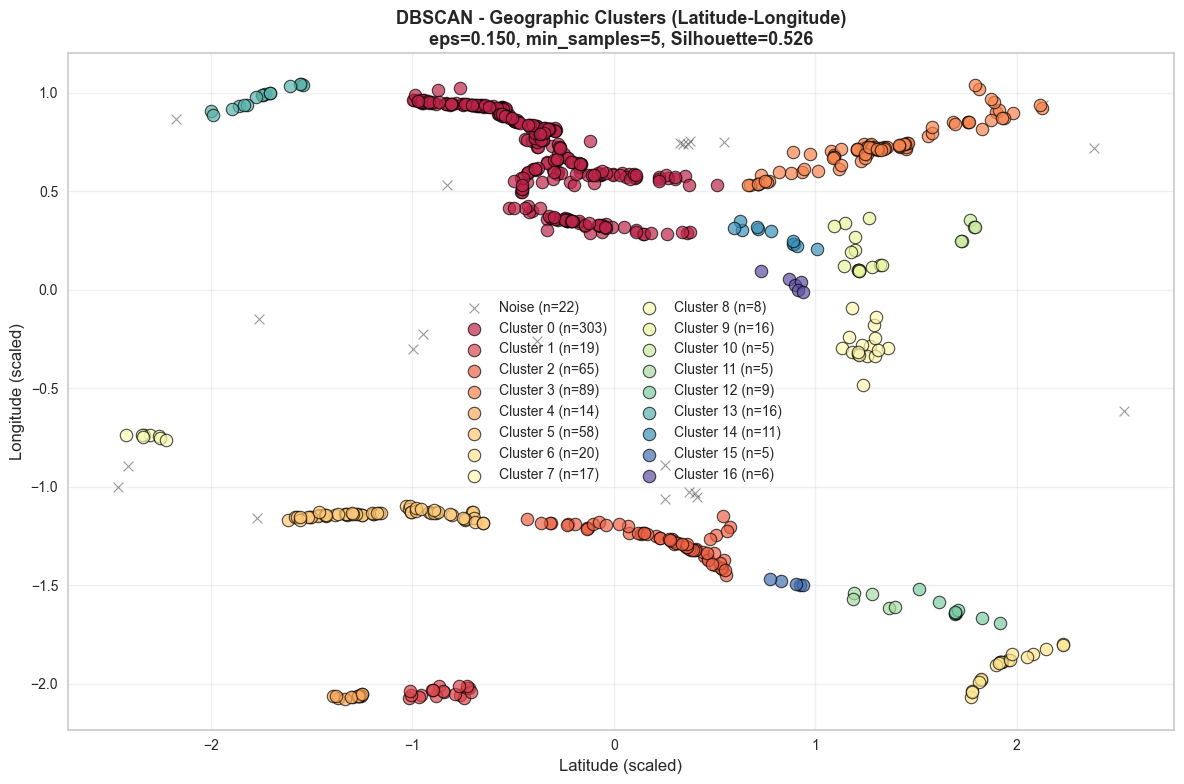

In [104]:
# 2D Scatter plot for Latitude-Longitude (Geographic clusters)
result_geo = dbscan_optimized_results[1]  # Latitude-Longitude
labels_geo = result_geo['labels']
features_geo = lat_long

plt.figure(figsize=(12, 8))

unique_labels = sorted(set(labels_geo))
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points in black
        color = 'black'
        marker = 'x'
        alpha = 0.4
        size = 50
        cluster_label = 'Noise'
    else:
        marker = 'o'
        alpha = 0.7
        size = 80
        cluster_label = f'Cluster {label}'
    
    class_mask = labels_geo == label
    plt.scatter(features_geo[class_mask, 0], 
               features_geo[class_mask, 1],
               c=[color], marker=marker, s=size, alpha=alpha,
               label=f'{cluster_label} (n={class_mask.sum()})',
               edgecolors='black', linewidth=0.8)

plt.title(f'DBSCAN - Geographic Clusters (Latitude-Longitude)\n' +
         f'eps={result_geo["eps"]:.3f}, min_samples={result_geo["min_samples"]}, ' +
         f'Silhouette={result_geo["silhouette"]:.3f}',
         fontsize=13, fontweight='bold')
plt.xlabel('Latitude (scaled)', fontsize=12)
plt.ylabel('Longitude (scaled)', fontsize=12)
plt.legend(loc='best', fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\matti\AppData\Local\Temp\ipykernel_32072\139541076.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(features_intensity[class_mask, 0],


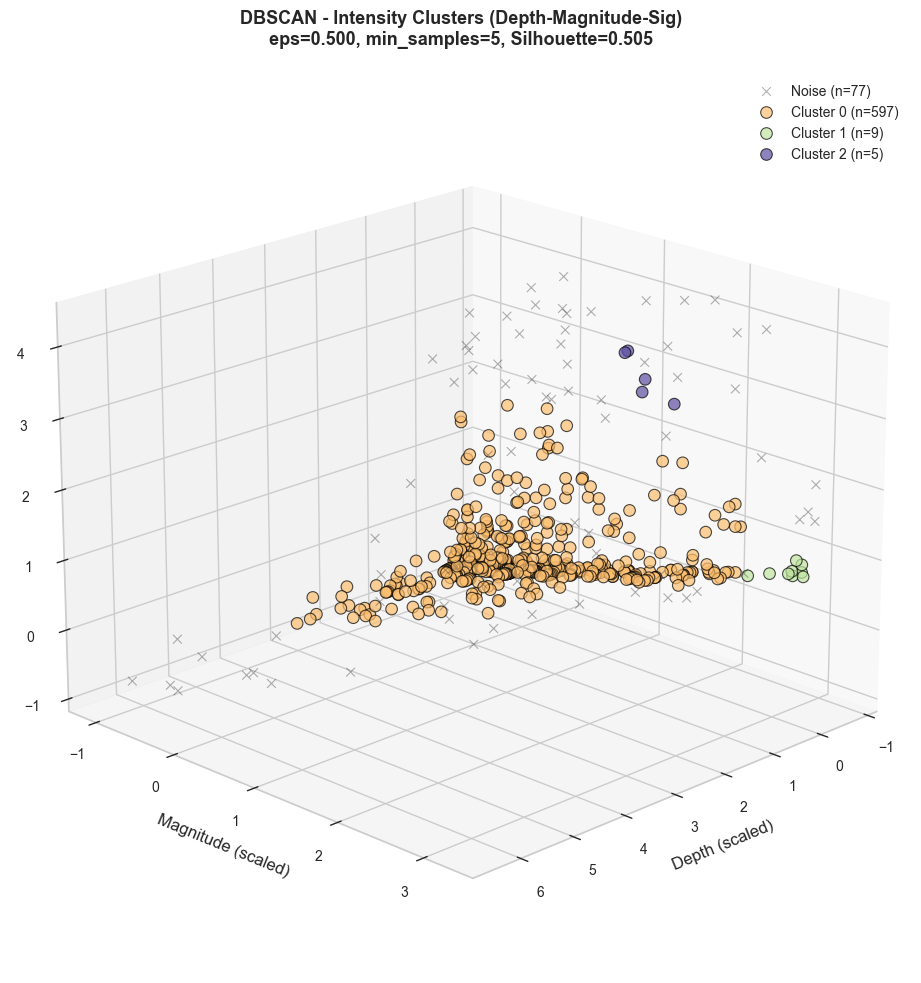

In [105]:
# 3D Scatter plot for Depth-Magnitude-Sig (Intensity clusters)
result_intensity = dbscan_optimized_results[0]  # Depth-Magnitude-Sig
labels_intensity = result_intensity['labels']
features_intensity = depth_magn_sig

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = sorted(set(labels_intensity))
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points
        color = 'black'
        marker = 'x'
        alpha = 0.3
        size = 40
        cluster_label = 'Noise'
    else:
        marker = 'o'
        alpha = 0.7
        size = 70
        cluster_label = f'Cluster {label}'

    class_mask = labels_intensity == label
    ax.scatter(features_intensity[class_mask, 0],
               features_intensity[class_mask, 1],
               features_intensity[class_mask, 2],
               c=[color], marker=marker, s=size, alpha=alpha,
               label=f'{cluster_label} (n={class_mask.sum()})',
               edgecolors='black', linewidths=0.8,
               depthshade=True)

ax.set_xlabel('Depth (scaled)', fontsize=12, labelpad=10)
ax.set_ylabel('Magnitude (scaled)', fontsize=12, labelpad=10)
ax.set_zlabel('Sig (scaled)', fontsize=12, labelpad=10)
ax.set_title(f'DBSCAN - Intensity Clusters (Depth-Magnitude-Sig)\n' +
             f'eps={result_intensity["eps"]:.3f}, min_samples={result_intensity["min_samples"]}, ' +
             f'Silhouette={result_intensity["silhouette"]:.3f}',
             fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

### DBSCAN - Cluster Profiling

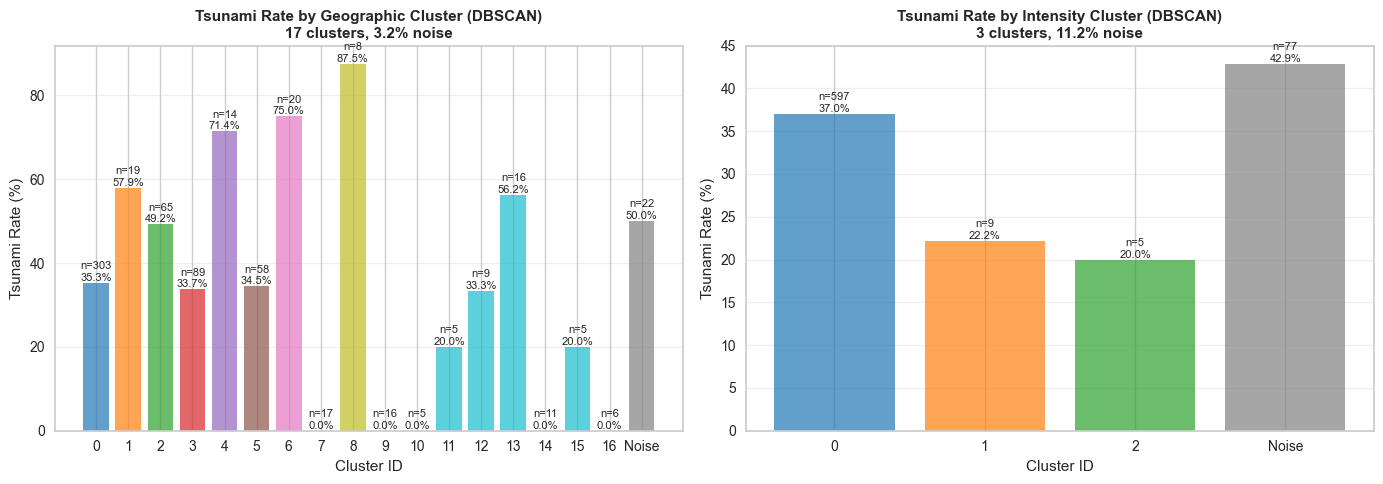

In [106]:
# Add cluster labels to original (cleaned) dataframe
X_clean_with_clusters_dbscan = X_clean.copy()
X_clean_with_clusters_dbscan['cluster_geo'] = dbscan_optimized_results[1]['labels']
X_clean_with_clusters_dbscan['cluster_intensity'] = dbscan_optimized_results[0]['labels']

# Add tsunami back for validation
tsunami_clean = df['tsunami'].iloc[X_clean.index]
X_clean_with_clusters_dbscan['tsunami'] = tsunami_clean.values

# Visualize tsunami rate per cluster (DBSCAN version)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (cluster_col, name, result) in enumerate([
    ('cluster_geo', 'Geographic', dbscan_optimized_results[1]),
    ('cluster_intensity', 'Intensity', dbscan_optimized_results[0])
]):
    tsunami_rates = []
    cluster_sizes = []
    cluster_ids = []

    # Get unique cluster IDs (excluding -1 for noise)
    unique_clusters = sorted(
        [c for c in X_clean_with_clusters_dbscan[cluster_col].unique() if c != -1])

    # Calculate tsunami rate for each valid cluster
    for cluster in unique_clusters:
        cluster_data = X_clean_with_clusters_dbscan[X_clean_with_clusters_dbscan[cluster_col] == cluster]
        tsunami_rate = cluster_data['tsunami'].mean() * 100
        tsunami_rates.append(tsunami_rate)
        cluster_sizes.append(len(cluster_data))
        cluster_ids.append(cluster)

    # Add noise points separately
    noise_data = X_clean_with_clusters_dbscan[X_clean_with_clusters_dbscan[cluster_col] == -1]
    if len(noise_data) > 0:
        tsunami_rates.append(noise_data['tsunami'].mean() * 100)
        cluster_sizes.append(len(noise_data))
        cluster_ids.append('Noise')

    # Plot
    x_positions = range(len(cluster_ids))
    colors_map = plt.cm.tab10(range(len(unique_clusters)))
    bar_colors = list(colors_map) + \
        ['gray'] if 'Noise' in cluster_ids else list(colors_map)

    bars = axes[idx].bar(x_positions, tsunami_rates,
                         color=bar_colors, alpha=0.7)
    axes[idx].set_xlabel('Cluster ID', fontsize=11)
    axes[idx].set_ylabel('Tsunami Rate (%)', fontsize=11)
    axes[idx].set_title(f'Tsunami Rate by {name} Cluster (DBSCAN)\n' +
                        f'{len(unique_clusters)} clusters, {result["noise_pct"]:.1f}% noise',
                        fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x_positions)
    axes[idx].set_xticklabels(cluster_ids)
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Add cluster size as text on bars
    for i, (bar, size, rate) in enumerate(zip(bars, cluster_sizes, tsunami_rates)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                       f'n={size}\n{rate:.1f}%',
                       ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## PCA

### Feature Selection for PCA

In [83]:
pca_features = ['magnitude', 'depth', 'latitude', 'longitude','cdi','sig','mmi']

# Create feature matrix for PCA
X_pca_features = X_clean[pca_features].values

# Scale features
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca_features)

### PCA with Selected Features

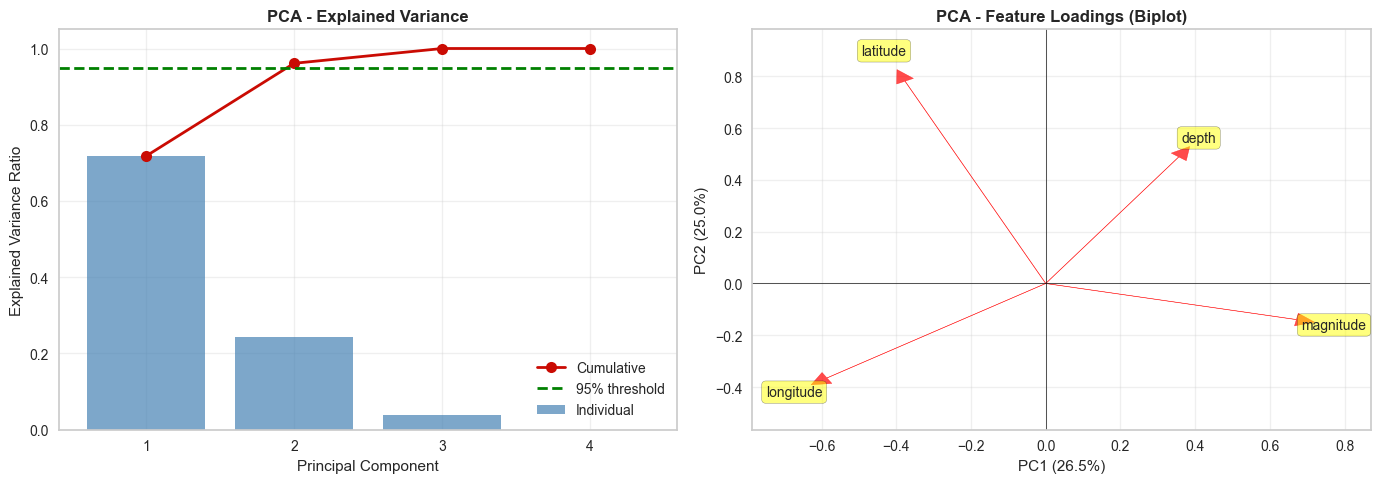


PCA ANALYSIS SUMMARY

Input features (4): magnitude, depth, latitude, longitude

Explained Variance by Component:
  PC1: 71.77% (cumulative: 71.77%)
  PC2: 24.34% (cumulative: 96.11%)
  PC3:  3.88% (cumulative: 100.00%)
  PC4:  0.00% (cumulative: 100.00%)

✓ Components needed for 95% variance: 2

✓ PCA transformation complete:
  Original dimensions: (688, 4)
  Reduced dimensions: (688, 2)
  Total variance explained: 51.52%


In [90]:
# Apply PCA with optimal number of components
# Test different number of components

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Explained Variance Analysis
pca_full = PCA().fit(X_pca_features)
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance, 
           alpha=0.7, label='Individual', color='steelblue')
axes[0].plot(range(1, len(explained_variance) + 1), cumulative_variance, 
            'r-o', linewidth=2, markersize=8, label='Cumulative')
axes[0].axhline(y=0.95, color='green', linestyle='--', linewidth=2, 
               label='95% threshold')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('PCA - Explained Variance', fontsize=12, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, len(explained_variance) + 1))

# 2. Component loadings (first 2 PCs)
pca_2d = PCA(n_components=2).fit(X_pca_scaled)
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)

# Biplot
for i, feature in enumerate(pca_features):
    axes[1].arrow(0, 0, loadings[i, 0], loadings[i, 1],
                 head_width=0.05, head_length=0.05, fc='red', ec='red', alpha=0.7)
    axes[1].text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature,
                fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[1].set_title('PCA - Feature Loadings (Biplot)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='k', linewidth=0.5)
axes[1].axvline(x=0, color='k', linewidth=0.5)
axes[1].set_xlim(loadings[:, 0].min() - 0.2, loadings[:, 0].max() + 0.2)
axes[1].set_ylim(loadings[:, 1].min() - 0.2, loadings[:, 1].max() + 0.2)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("PCA ANALYSIS SUMMARY")
print("="*80)
print(f"\nInput features ({len(pca_features)}): {', '.join(pca_features)}")
print(f"\nExplained Variance by Component:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"  PC{i}: {var*100:5.2f}% (cumulative: {cum_var*100:5.2f}%)")

# Determine optimal number of components (95% variance)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\n✓ Components needed for 95% variance: {n_components_95}")

# Apply PCA with 2 components for visualization
pca_final = PCA(n_components=2)
X_pca_2d = pca_final.fit_transform(X_pca_scaled)

print(f"\n✓ PCA transformation complete:")
print(f"  Original dimensions: {X_pca_scaled.shape}")
print(f"  Reduced dimensions: {X_pca_2d.shape}")
print(f"  Total variance explained: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")
print("="*80)

### K-Means Clustering on PCA-reduced Data

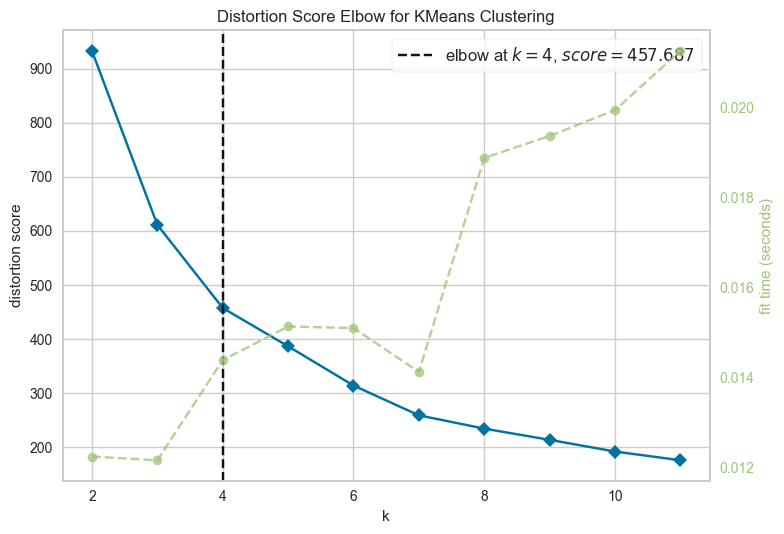

In [91]:
# Elbow method to find optimal k
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(X_pca_2d)
visualizer.finalize()

plt.tight_layout()
plt.show()

### DBSCAN - Finding Optimal Epsilon for PCA Data

C:\Users\matti\AppData\Local\Temp\ipykernel_32072\851022926.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


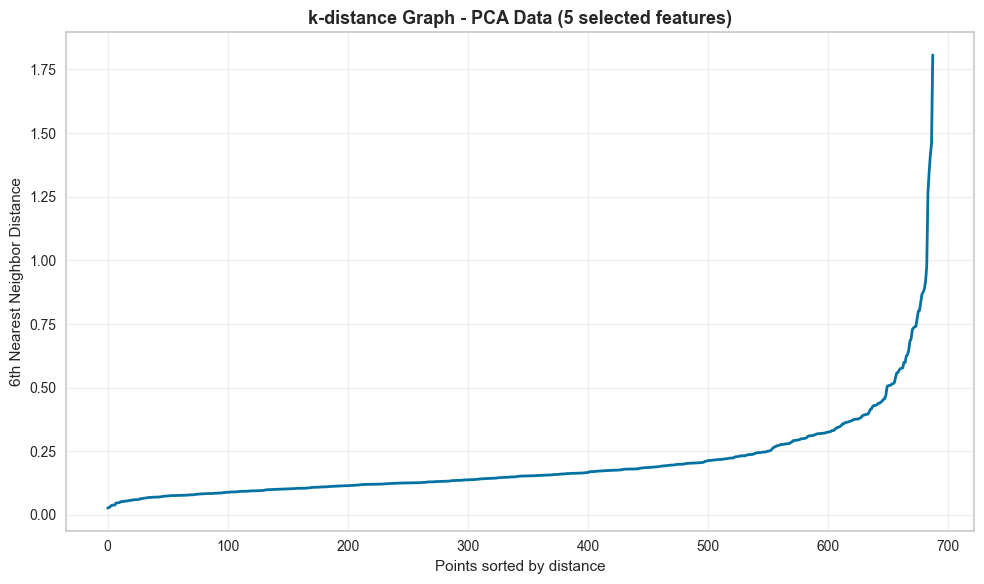

In [92]:
# K-distance graph for PCA-reduced data
min_samples_pca = 5
neighbors_number_pca = 6

neighbors = NearestNeighbors(n_neighbors=neighbors_number_pca)
neighbors_fit = neighbors.fit(X_pca_2d)
distances, indices = neighbors_fit.kneighbors(X_pca_2d)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, neighbors_number_pca - 1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.title('k-distance Graph - PCA Data (5 selected features)', fontsize=13, fontweight='bold')
plt.xlabel('Points sorted by distance', fontsize=11)
plt.ylabel(f'{neighbors_number_pca}th Nearest Neighbor Distance', fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## PCA Clustering Results

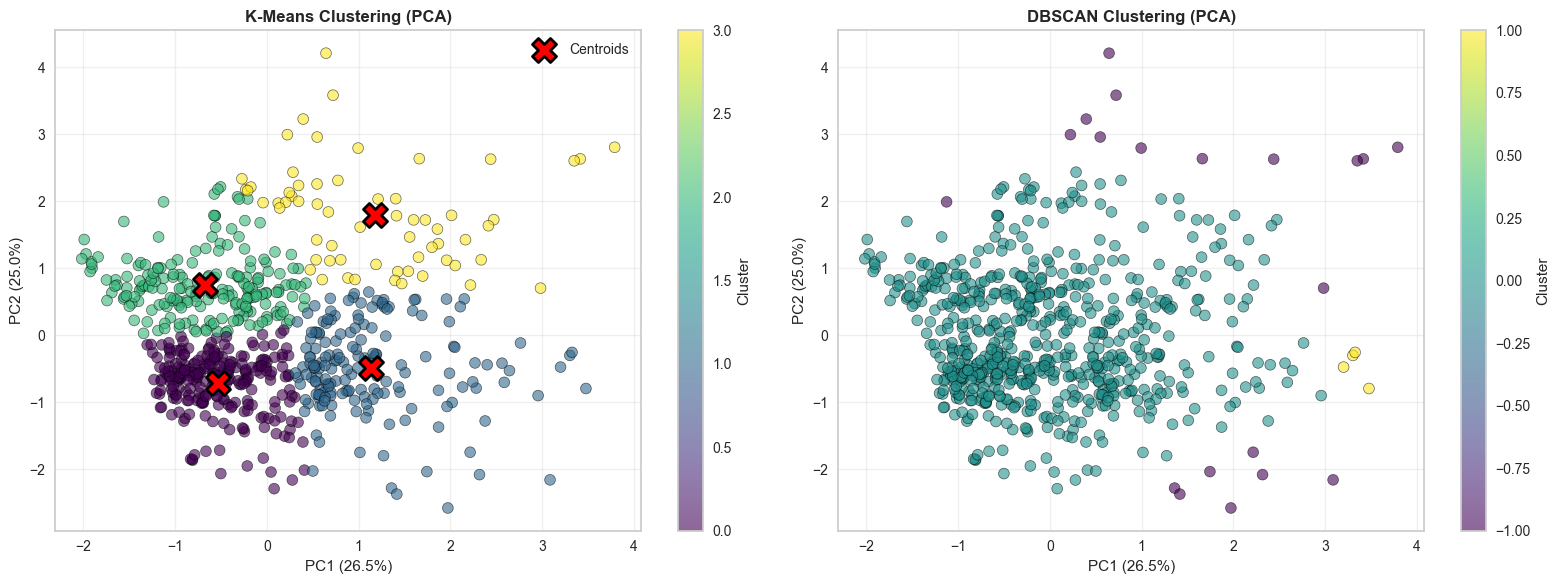

In [ ]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans_pca = kmeans_pca.fit_predict(X_pca_2d)

dbscan_pca = DBSCAN(eps=0.5, min_samples=5)
y_dbscan_pca = dbscan_pca.fit_predict(X_pca_2d)

fig, ax_clusters = plt.subplots(1, 2, figsize=(16, 6))

# K-Means visualization
scatter_km = ax_clusters[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                    c=y_kmeans_pca, cmap='viridis', 
                                    s=60, alpha=0.6, edgecolors='black', linewidth=0.5)
ax_clusters[0].scatter(kmeans_pca.cluster_centers_[:, 0], 
                      kmeans_pca.cluster_centers_[:, 1],
                      c='red', s=300, alpha=1, marker='X',
                      edgecolors='black', linewidth=2, label='Centroids')
ax_clusters[0].set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax_clusters[0].set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax_clusters[0].set_title('K-Means Clustering (PCA)', fontsize=12, fontweight='bold')
ax_clusters[0].legend()
ax_clusters[0].grid(True, alpha=0.3)
plt.colorbar(scatter_km, ax=ax_clusters[0], label='Cluster')

# DBSCAN visualization
scatter_db = ax_clusters[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                    c=y_dbscan_pca, cmap='viridis', 
                                    s=60, alpha=0.6, edgecolors='black', linewidth=0.5)
ax_clusters[1].set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax_clusters[1].set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax_clusters[1].set_title('DBSCAN Clustering (PCA)', fontsize=12, fontweight='bold')
ax_clusters[1].grid(True, alpha=0.3)
plt.colorbar(scatter_db, ax=ax_clusters[1], label='Cluster')

plt.tight_layout()
plt.show()